In [5]:
from __future__ import print_function

from six import iteritems

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as pl

import itertools as it

import json

import os


def slice_df(df, start_end):
    """
    This slices a dataframe when the index column is the time. This function slices the dataframe 'df' between a window
    defined by the 'start_end' parameter. Time is given in seconds.
    """
    
    inds = (df.index >= start_end[0]) & (df.index < start_end[1])
    return df[inds]


def slice_df_start_stop(df, start_end):
    """
    Some data, eg PIR sensor data and annotation data, are stored in a sparse format in which the 'start' and 'stop'
    times are stored. This helper function returns the sequences of a dataframe which fall within a window defined
    by the 'start_stop' parameter.
    """
    
    inds = (df.start < start_end[1]) & (df.end >= start_end[0])
    return df[inds]


class Slicer(object):
    """
    This class provides an interface to querying a dataframe object. Specifically, this is used to query the times for
    which
    """

    def __init__(self):
        pass
    
    def _time_of(self, dataframe, label):
        dict_list = dataframe.T.to_dict().values()
        filtered = filter(lambda aa: aa['name'] == label, dict_list)
        annotations = sorted(filtered, key=lambda ann: ann['start'])
        
        return [(ann['start'], ann['end']) for ann in annotations]
    
    def _times_of(self, dataframes, label):
        times = [self._time_of(dataframe, label) for dataframe in dataframes]
        
        return times
    
    def times_of_occupancy(self, location):
        return self._times_of(self.locations, location)
    
    def times_of_activity(self, activity):
        return self._times_of(self.annotations, activity)
    
    def time_of_occupancy(self, location, index):
        start_end = filter(lambda se: len(se) > index, self._times_of(self.locations, location))
        
        return np.asarray([se[index] for se in start_end])
    
    def time_of_activity(self, activity, index):
        start_end = filter(lambda se: len(se) > index, self._times_of(self.annotations, activity))
        
        return np.asarray([se[index] for se in start_end])


class Sequence(Slicer):
    def __init__(self, meta_root, data_path):
        super(Sequence, self).__init__()
        
        self.path = data_path
        
        video_cols = json.load(open(os.path.join(meta_root, 'video_feature_names.json')))
        self.centre_2d = video_cols['centre_2d']
        self.bb_2d = video_cols['bb_2d']
        self.centre_3d = video_cols['centre_3d']
        self.bb_3d = video_cols['bb_3d']
        
        self.annotations_loaded = False
        
        self.meta = json.load(open(os.path.join(data_path, 'meta.json')))
        self.acceleration_keys = json.load(open(os.path.join(meta_root, 'accelerometer_axes.json')))
        self.rssi_keys = json.load(open(os.path.join(meta_root, 'access_point_names.json')))
        self.video_names = json.load(open(os.path.join(meta_root, 'video_locations.json')))
        self.pir_names = json.load(open(os.path.join(meta_root, 'pir_locations.json')))
        self.location_targets = json.load(open(os.path.join(meta_root, 'rooms.json')))
        self.activity_targets = json.load(open(os.path.join(meta_root, 'annotations.json')))
        
        self.load()
    
    def load_wearable(self):
        accel_rssi = pd.read_csv(os.path.join(self.path, 'acceleration.csv'), index_col='t')
        self.acceleration = accel_rssi[self.acceleration_keys]
        self.rssi = pd.DataFrame(index=self.acceleration.index)
        for kk in self.rssi_keys:
            if kk in accel_rssi:
                self.rssi[kk] = accel_rssi[kk]
            
            else:
                self.rssi[kk] = np.nan
                accel_rssi[kk] = np.nan
        
        self.accel_rssi = accel_rssi
        self.wearable_loaded = True
    
    def load_environmental(self):
        self.pir = pd.read_csv(os.path.join(self.path, 'pir.csv'))
        self.pir_loaded = True
    
    def load_video(self):
        self.video = dict()
        for location in self.video_names:
            filename = os.path.join(self.path, 'video_{}.csv'.format(location))
            self.video[location] = pd.read_csv(filename, index_col='t')
        
        self.video_loaded = True
    
    def load_annotations(self):
        self.num_annotators = 0
        
        self.annotations = []
        self.locations = []

        self.targets = None 

        targets_file_name = os.path.join(self.path, 'targets.csv')
        if os.path.exists(targets_file_name): 
            self.targets = pd.read_csv(targets_file_name)
        
        while True:
            annotation_filename = "{}/annotations_{}.csv".format(self.path, self.num_annotators)
            location_filename = "{}/location_{}.csv".format(self.path, self.num_annotators)
            
            if not os.path.exists(annotation_filename):
                break
            
            self.annotations.append(pd.read_csv(annotation_filename))
            self.locations.append(pd.read_csv(location_filename))
            
            self.num_annotators += 1
        
        self.annotations_loaded = self.num_annotators != 0
    
    def load(self):
        self.load_wearable()
        self.load_video()
        self.load_environmental()
        self.load_annotations()

    def iterate(self):
        start = range(int(self.meta['end']) + 1)
        end = range(1, int(self.meta['end']) + 2)

        pir_zeros = [np.zeros(10)] * len(self.pir_names)
        pir_t = np.linspace(0, 1, 10, endpoint=False)
        pir_df = pd.DataFrame(dict(zip(self.pir_names, pir_zeros)))
        pir_df['t'] = pir_t
        pir_df.set_index('t', inplace=True)

        for lower, upper in zip(start, end):
            lu = (lower, upper)

            # Acceleration/RSSI
            acceleration = slice_df(self.acceleration, lu)
            rssi = slice_df(self.rssi, lu)

            # PIR
            pir_start_stop = slice_df_start_stop(self.pir, lu)
            pir_df *= 0.0
            if pir_start_stop.shape[0] > 0:
                for si, series in pir_start_stop.iterrows():
                    pir_df[series['name']] = 1.0

            pir_t += 1

            # Video
            video_living_room = slice_df(self.video['living_room'], lu)
            video_kitchen = slice_df(self.video['kitchen'], lu)
            video_hallway = slice_df(self.video['hallway'], lu)

            yield lu, (acceleration, rssi, pir_df.copy(), video_living_room, video_kitchen, video_hallway)


class SequenceVisualisation(Sequence):
    def __init__(self, meta_root, data_path):
        super(SequenceVisualisation, self).__init__(meta_root, data_path)
    
    def get_offsets(self):
        if self.num_annotators == 1:
            return [0]
        
        elif self.num_annotators == 2:
            return [-0.05, 0.05]
        
        elif self.num_annotators == 3:
            return [-0.1, 0.0, 0.1]
    
    def plot_annotators(self, ax, lu):
        if self.annotations_loaded == False:
            return
        
        pl.sca(ax)
        
        palette = it.cycle(sns.color_palette())
        
        offsets = self.get_offsets()
        for ai in range(self.num_annotators):
            col = next(palette)
            offset = offsets[ai]
            
            for index, rr in slice_df_start_stop(self.annotations[ai], lu).iterrows():
                pl.plot([rr['start'], rr['end']], [self.activity_targets.index(rr['name']) + offset * 2] * 2, color=col,
                        linewidth=5)
        
        pl.yticks(np.arange(len(self.activity_targets)), self.activity_targets)
        pl.ylim((-1, len(self.activity_targets)))
        pl.xlim(lu)
    
    def plot_locations(self, ax, lu):
        if self.annotations_loaded == False:
            return
        
        pl.sca(ax)
        
        palette = it.cycle(sns.color_palette())
        
        offsets = self.get_offsets()
        for ai in range(self.num_annotators):
            col = next(palette)
            offset = offsets[ai]
            for index, rr in slice_df_start_stop(self.locations[ai], lu).iterrows():
                pl.plot([rr['start'], rr['end']], [self.location_targets.index(rr['name']) + offset * 2] * 2, color=col,
                        linewidth=5, alpha=0.5)
        
        pl.yticks(np.arange(len(self.location_targets)), self.location_targets)
        pl.ylim((-1, len(self.location_targets)))
        pl.xlim(lu)
    
    def plot_pir(self, lu, sharey=False):
        num = [2, 1][sharey]
        first = [0, 0][sharey]
        second = [1, 0][sharey]
        
        fig, axes = pl.subplots([2, 1][sharey], 1, sharex=True, sharey=False, figsize=(20, 5 * num))
        axes = np.atleast_1d(axes)
        
        pl.sca(axes[second])
        for index, rr in slice_df_start_stop(self.pir, lu).iterrows():
            pl.plot([rr['start'], rr['end']], [self.location_targets.index(rr['name'])] * 2, 'k')
        
        pl.yticks(np.arange(len(self.pir_names)), self.pir_names)
        pl.ylim((-1, len(self.pir_names)))
        pl.xlim(lu)
        pl.ylabel('PIR sensor')
        
        self.plot_locations(axes[first], lu)
        axes[first].set_ylabel('Ground truth')
        
        pl.tight_layout()
    
    def plot_acceleration(self, lu, with_annotations=True, with_locations=False):
        fig, ax = pl.subplots(1, 1, sharex=True, sharey=False, figsize=(20, 7.5))
        ax2 = pl.twinx()
        
        df = slice_df(self.acceleration, lu)
        df.plot(ax=ax, lw=0.75)
        ax.yaxis.grid(False, which='both')
        pl.xlim(lu)
        ax.set_ylabel('Acceleration (g)')
        ax.set_xlabel('Time (s)')
        
        if with_annotations:
            self.plot_annotators(ax2, lu)
        
        if with_locations:
            self.plot_locations(ax2, lu)
        
        pl.tight_layout()
    
    def plot_rssi(self, lu):
        fig, ax = pl.subplots(1, 1, sharex=True, sharey=False, figsize=(20, 5))
        ax2 = pl.twinx()
        
        df = slice_df(self.rssi, lu)
        df.plot(ax=ax, linewidth=0.25)
        ax.yaxis.grid(False, which='both')
        pl.xlim(lu)
        ax.set_ylabel('RSSI (dBm)')
        ax.set_xlabel('Time (s)')
        
        self.plot_locations(ax2, lu)
        
        pl.tight_layout()
    
    def plot_video(self, cols, lu):
        fig, axes = pl.subplots(3, 1, sharex=True, figsize=(20, 10))
        for vi, (kk, vv) in enumerate(iteritems(self.video)):
            x = np.asarray(vv.index.tolist())
            y = np.asarray(vv[cols])
            
            palette = it.cycle(sns.color_palette())
            pl.sca(axes[vi])
            
            for jj in range(y.shape[1]):
                col = next(palette)
                pl.scatter(x, y[:, jj], marker='o', color=col, s=2, label=cols[jj])
            pl.gca().grid(False, which='both')
            pl.ylabel(kk)
            pl.xlim(lu)
            
            self.plot_locations(pl.twinx(), lu)
        
        pl.tight_layout()
    
    def plot_all(self, plot_range=None):
        if plot_range is None:
            plot_range = (self.meta['start'], self.meta['end'])
        
        self.plot_pir(plot_range, sharey=True)
        self.plot_rssi(plot_range)
        self.plot_acceleration(plot_range)
        self.plot_video(self.centre_2d, plot_range)



In [6]:
def main(n):
    """
    This function will plot all of the sensor data that surrounds the first annotated activity.
    """
    
    # Load training data (this will contain labels)
    plotter = SequenceVisualisation('/SPHERE-Challenge/data/raw_data/public_data', '/SPHERE-Challenge/data/raw_data/public_data/train/'+n)
    
    # Or load testing data (this visualisation will not contain labels and are 
    # generally shorter sequences of data, between 10-30 seconds long)
    # plotter = SequenceVisualisation('public_data', 'public_data/train/00001')
    
    # This function will retreive the time range of the first jumping activity. 
    plot_range = plotter.times_of_activity('a_jump')
    print (plot_range)
    
    # To provide temporal context to this, we plot a time range of 10 seconds 
    # surrounding this time period
    plotter.plot_all()
    pl.show()



[[(1774.195, 1776.739)], [(1775.6870000000001, 1776.348), (1776.901, 1777.87)], [(1774.974, 1778.844)]]


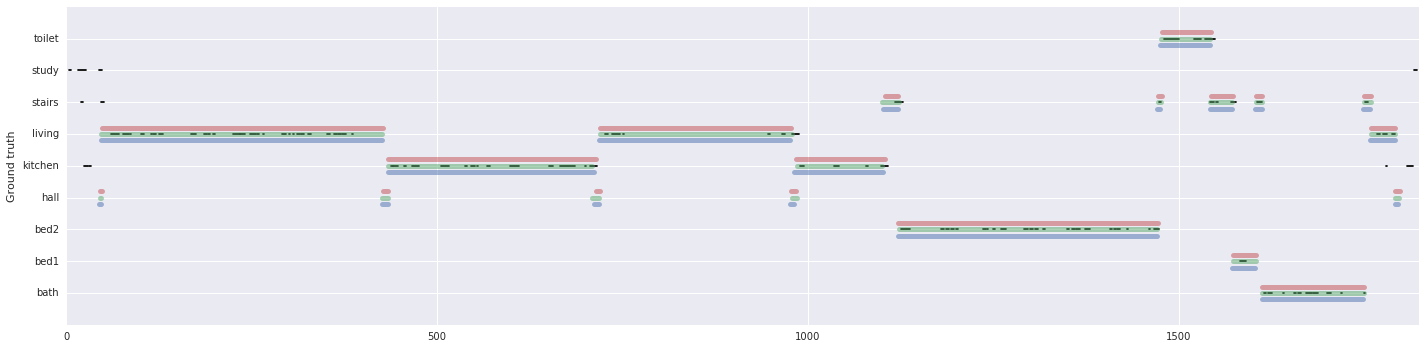

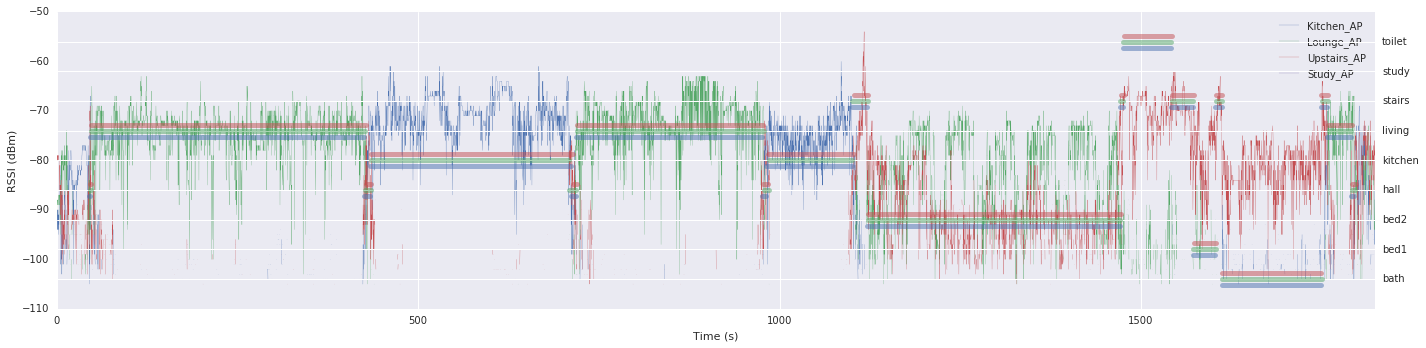

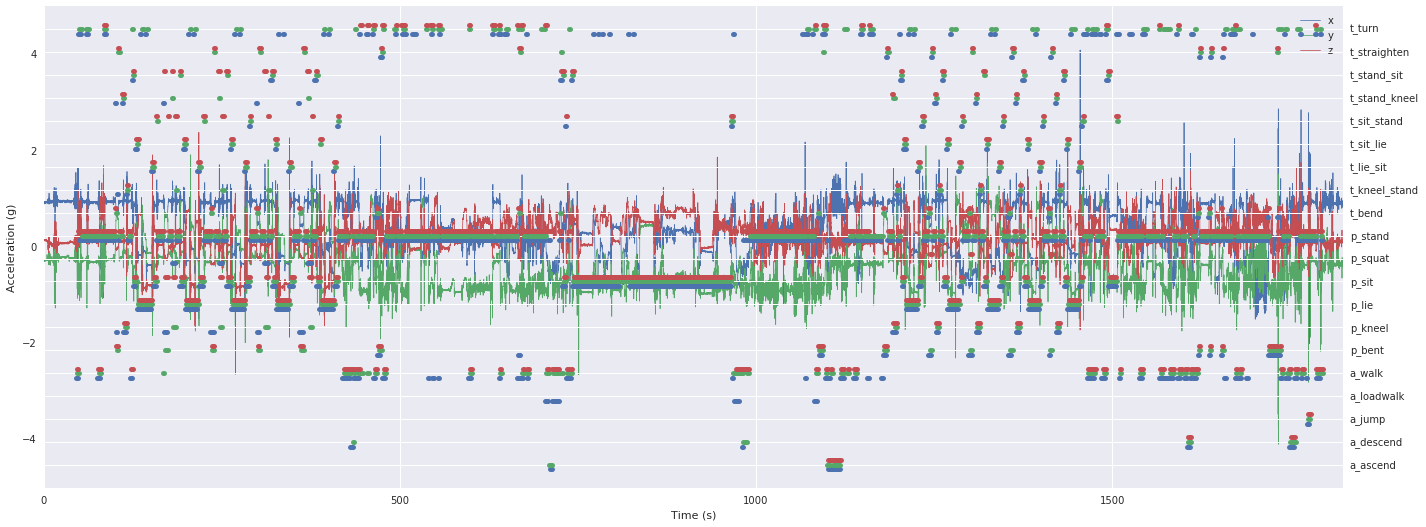

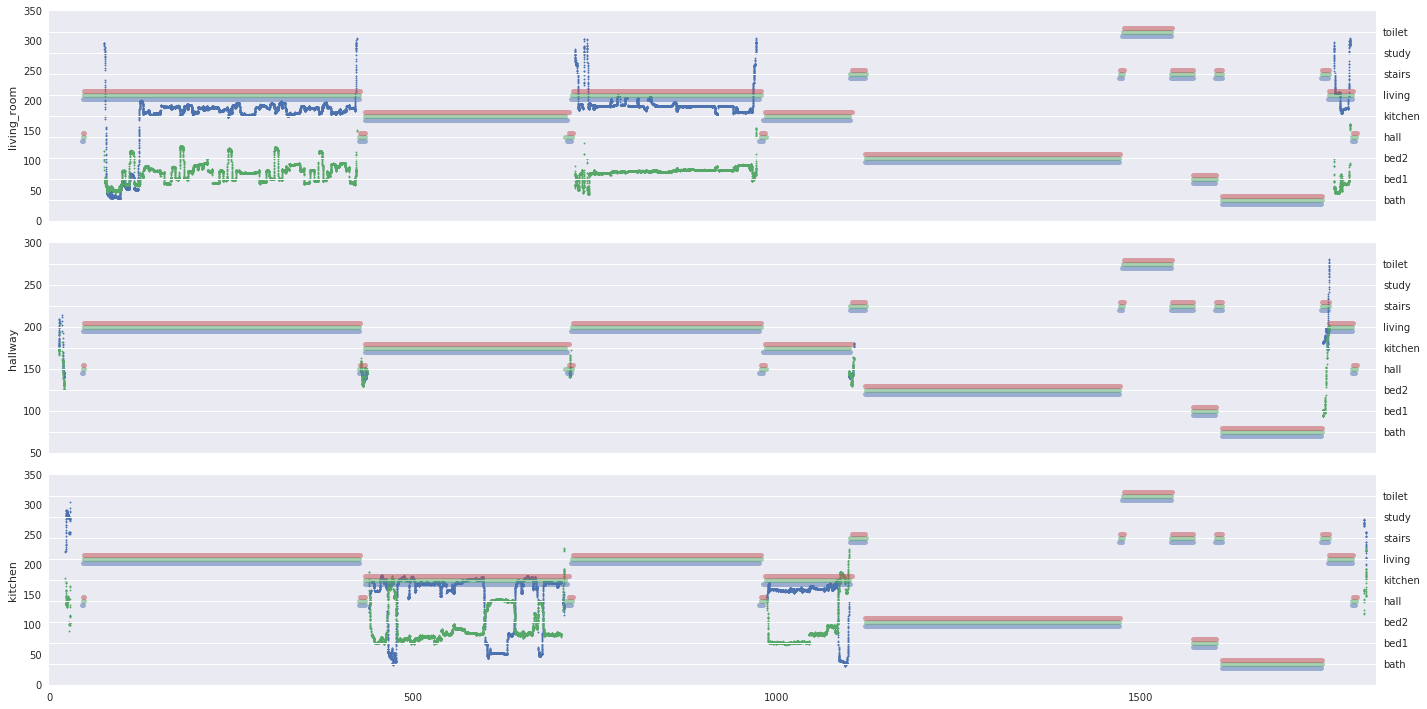

In [7]:
main('00001')

[[(34.264, 35.784)], [(33.722, 36.277), (1645.483, 1647.7120000000002)], [(34.02, 34.48), (34.945, 35.345), (1645.234, 1646.256), (1646.263, 1647.271)]]


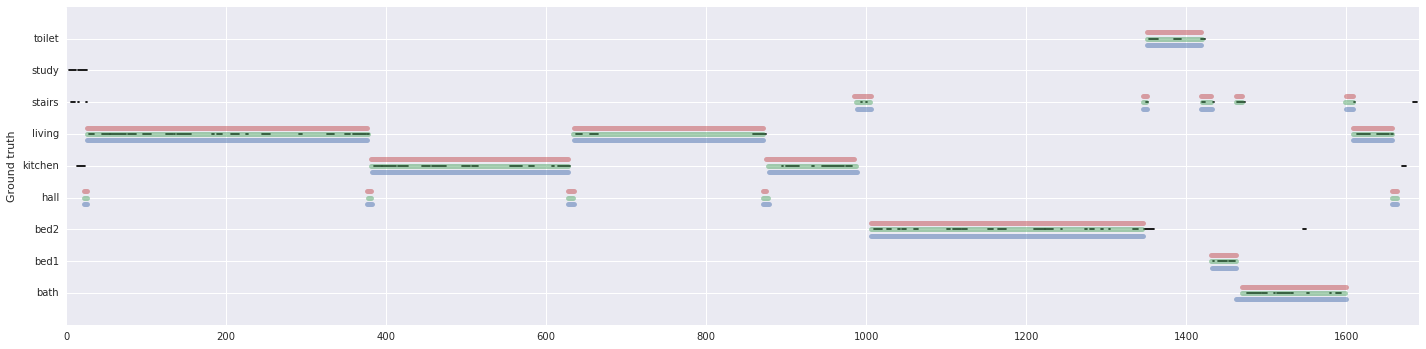

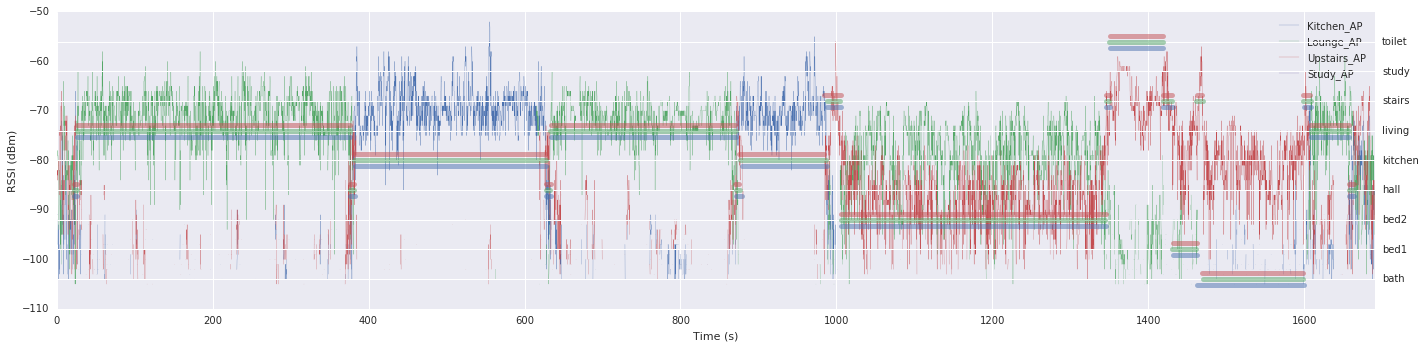

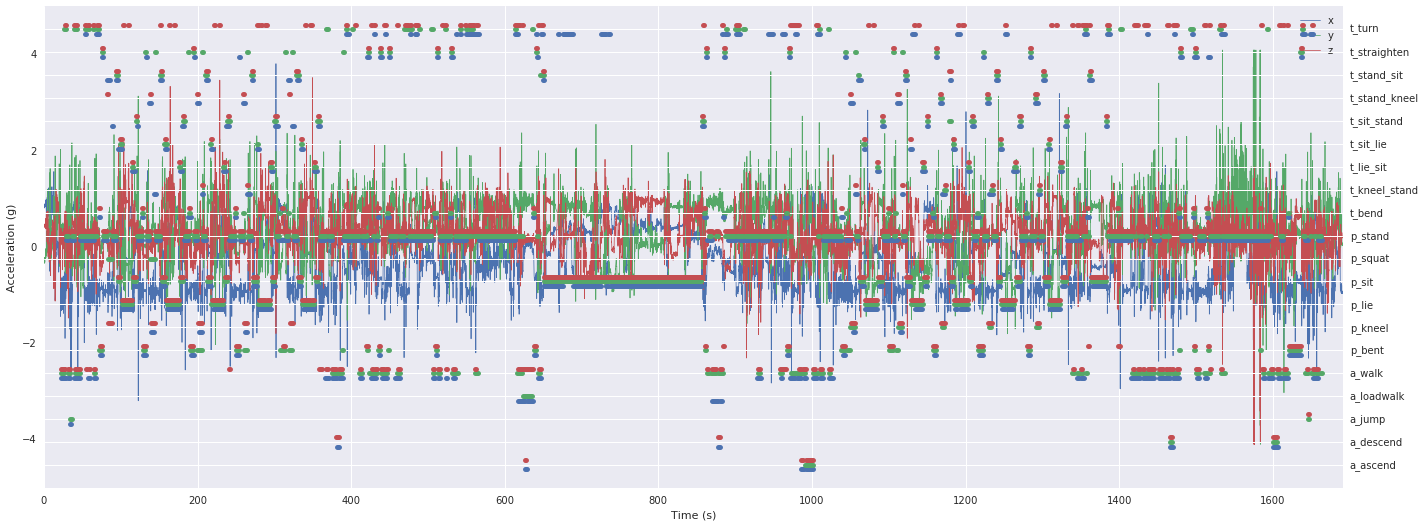

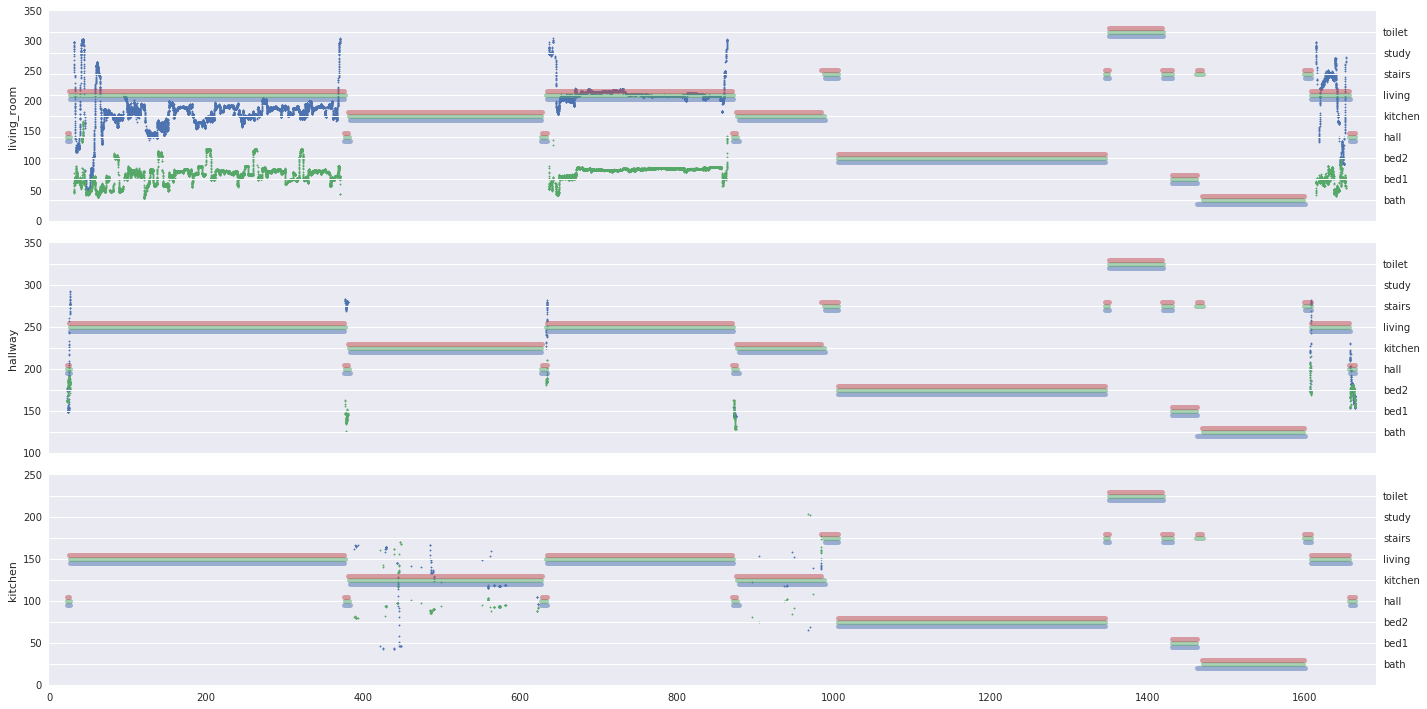

In [8]:
main('00002')

[[(94.42200000000001, 96.845), (1580.346, 1582.3629999999998)], [(93.405, 96.095), (1579.38, 1581.86)]]


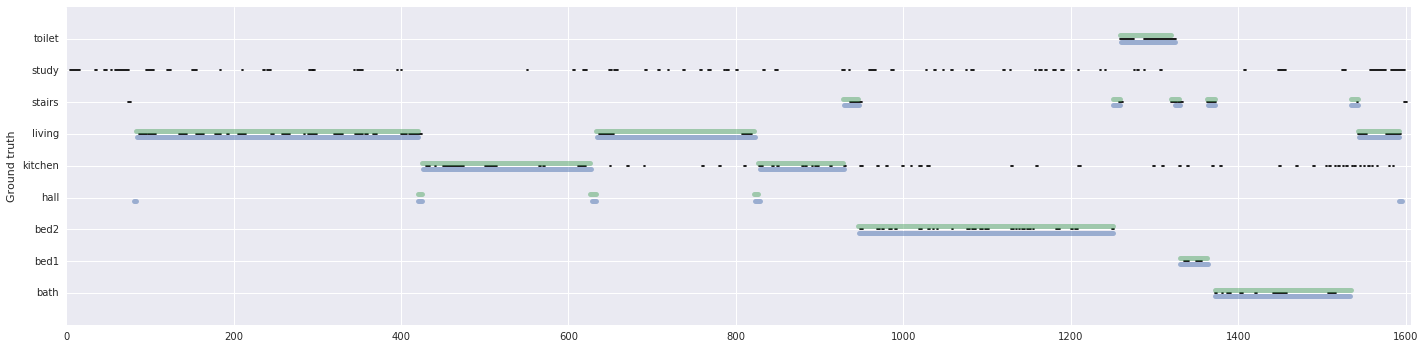

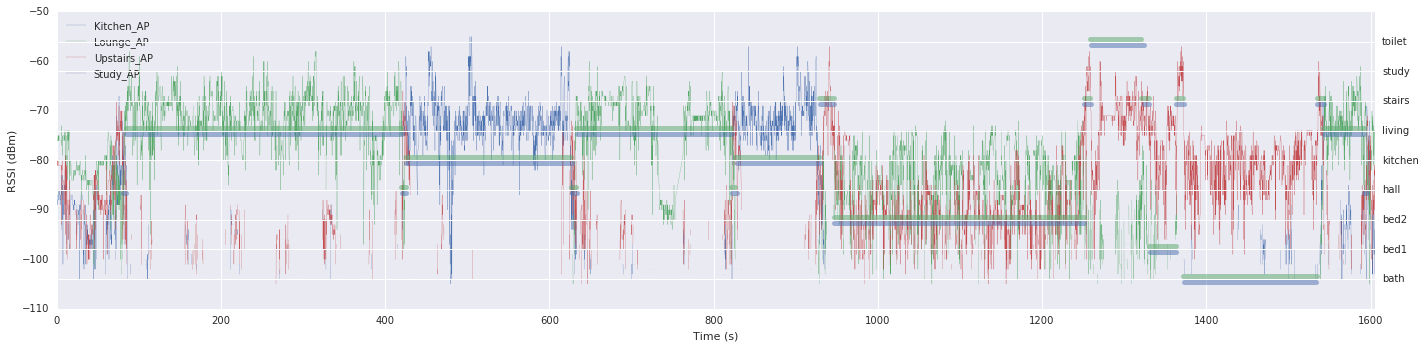

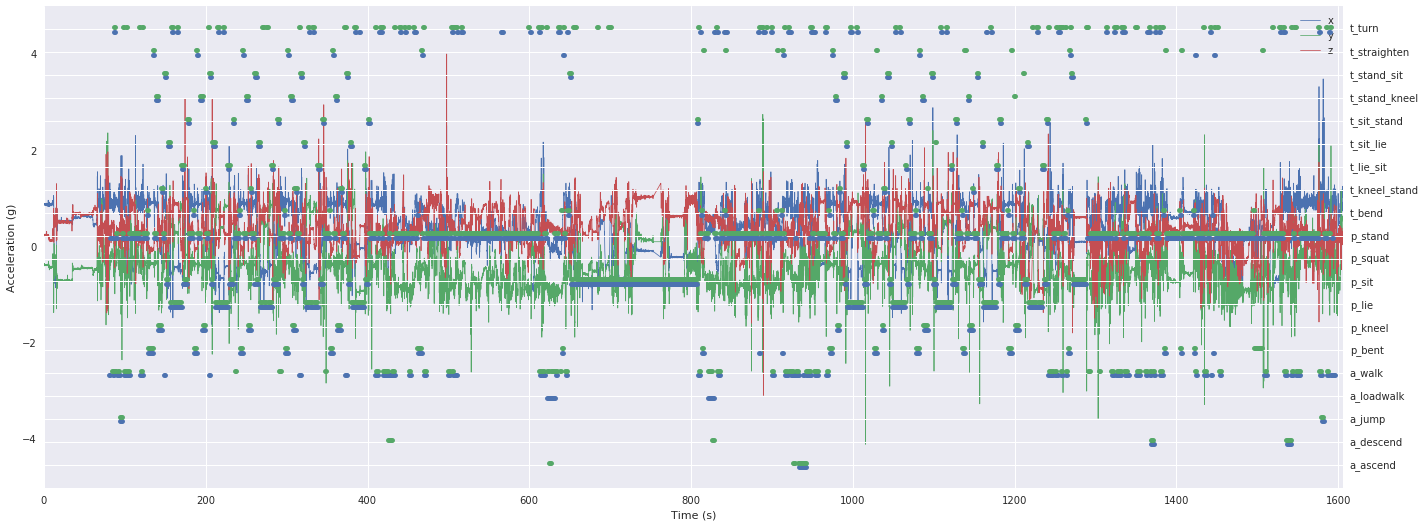

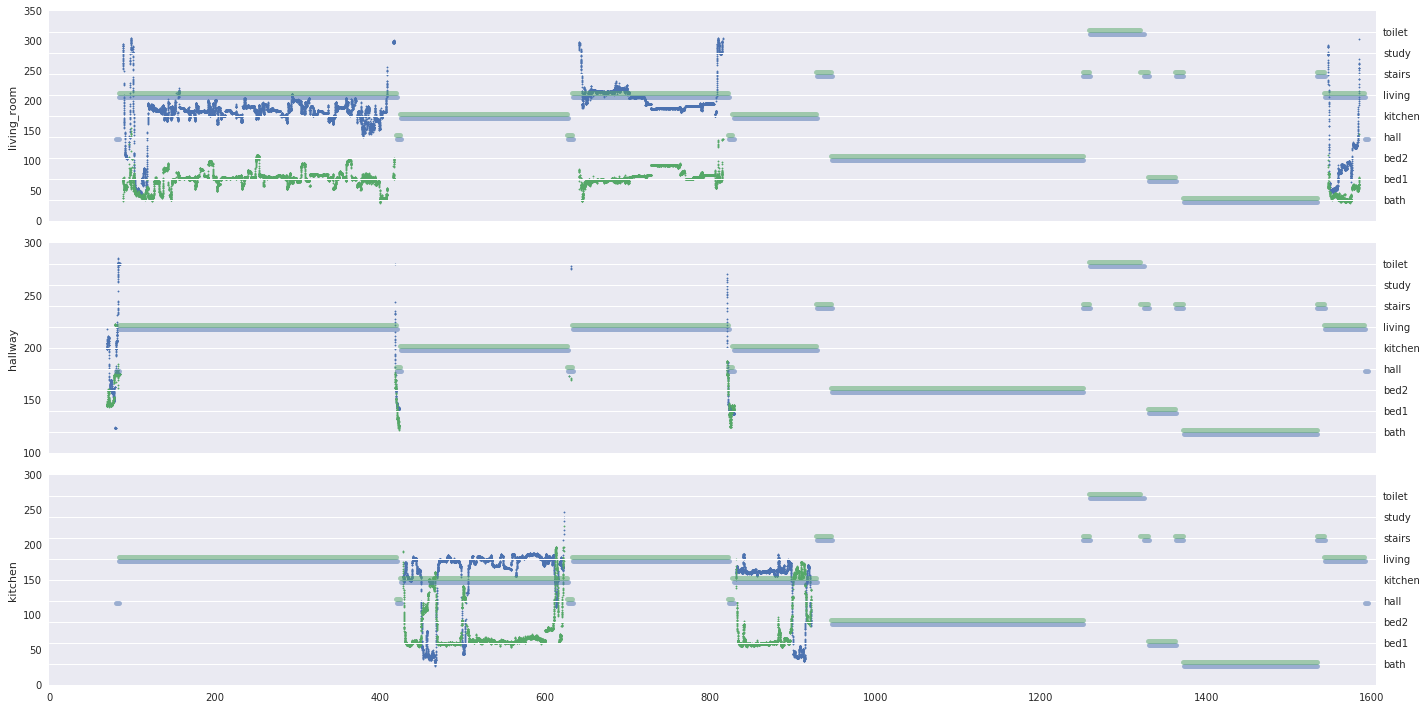

In [11]:
main('00003')

[[(40.525, 43.805), (1549.3329999999999, 1553.26)], [(40.738, 43.578), (1549.866, 1552.515)]]


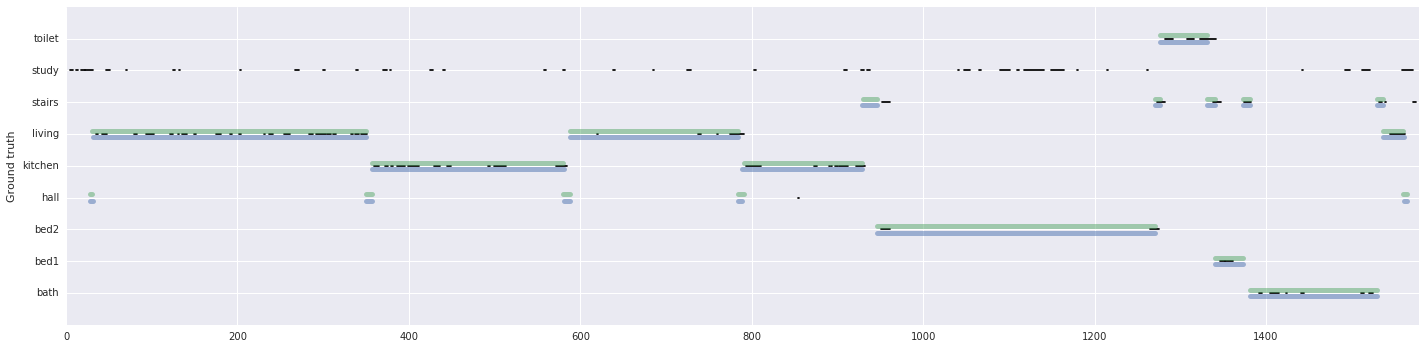

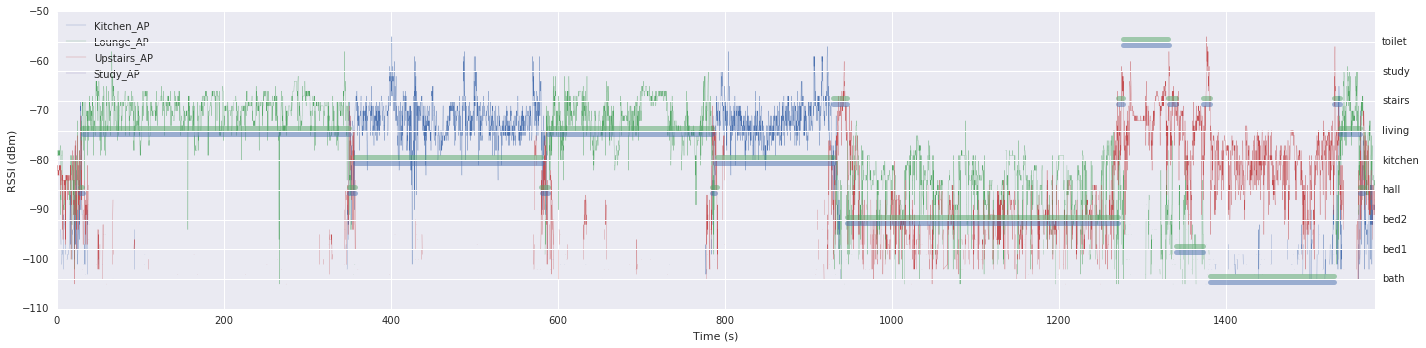

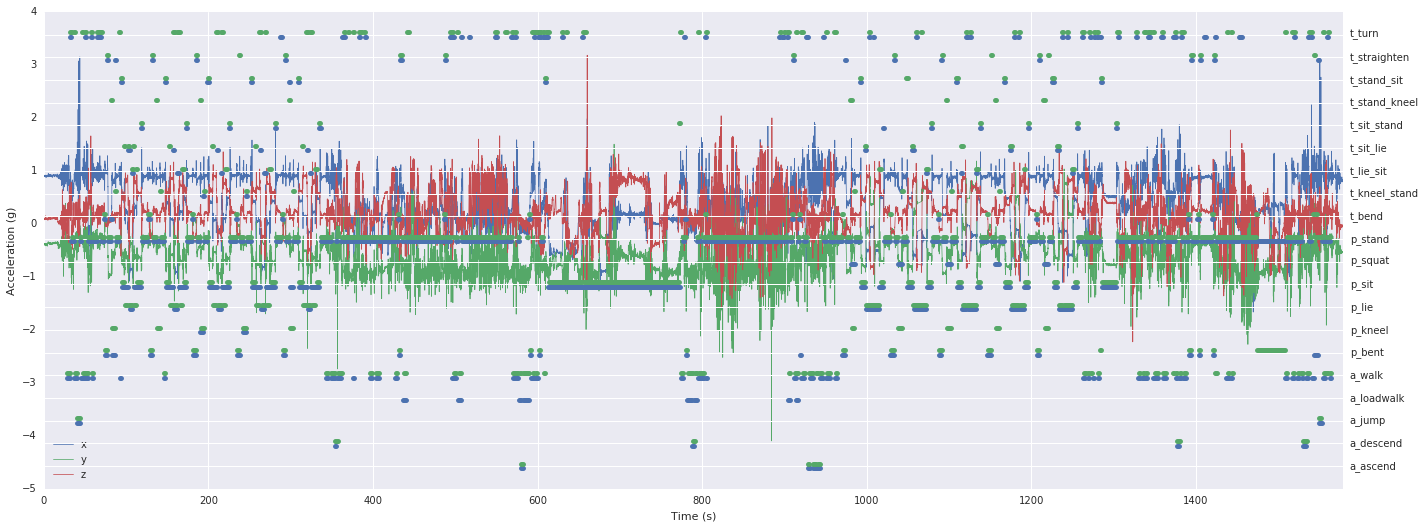

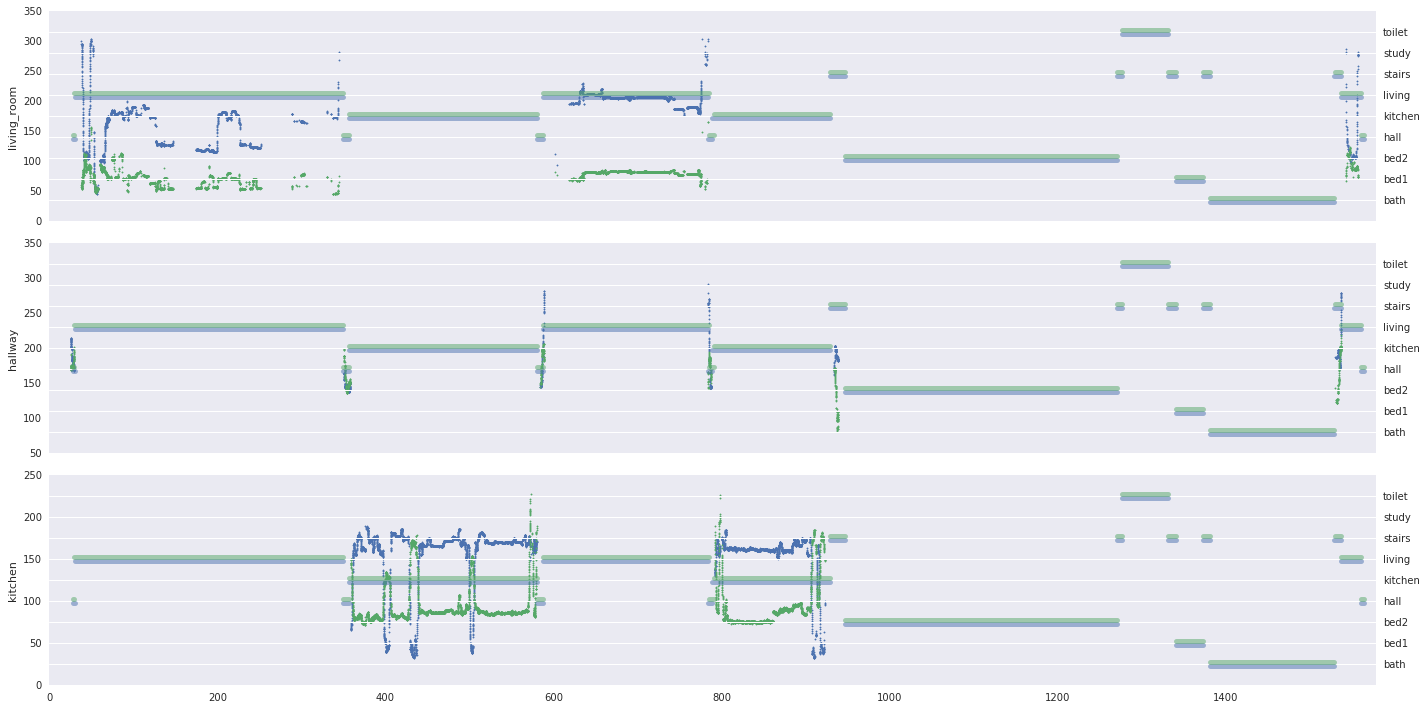

In [12]:
main('00004')

[[(58.132, 60.81), (1539.2079999999999, 1541.774)], [(58.065, 60.615), (1539.047, 1541.967)]]


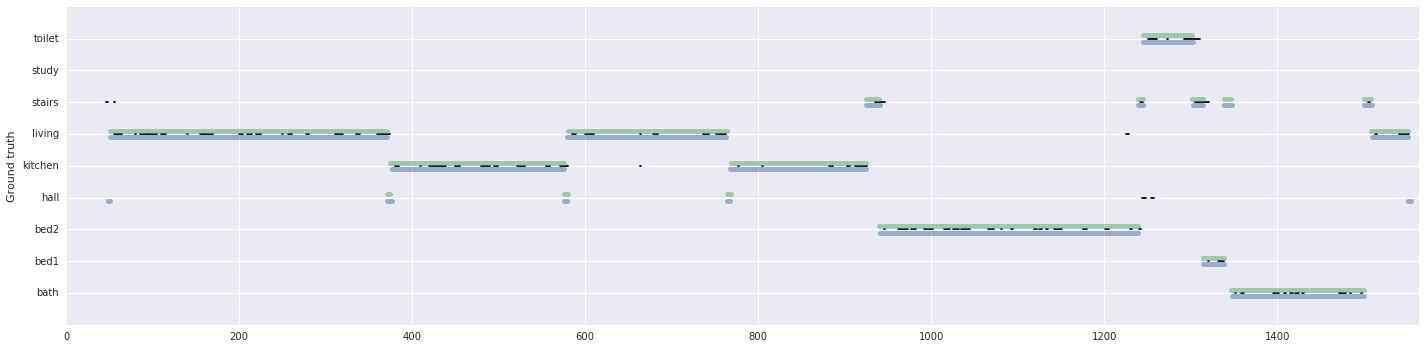

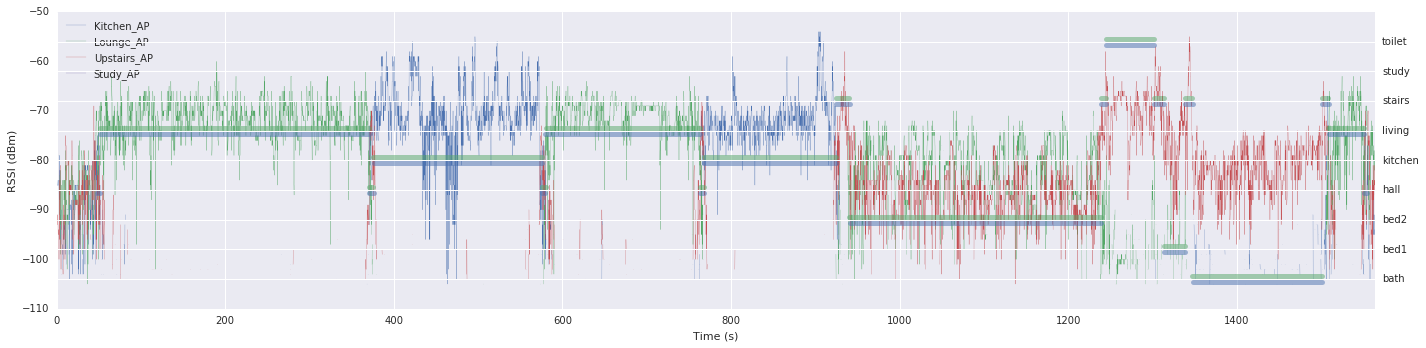

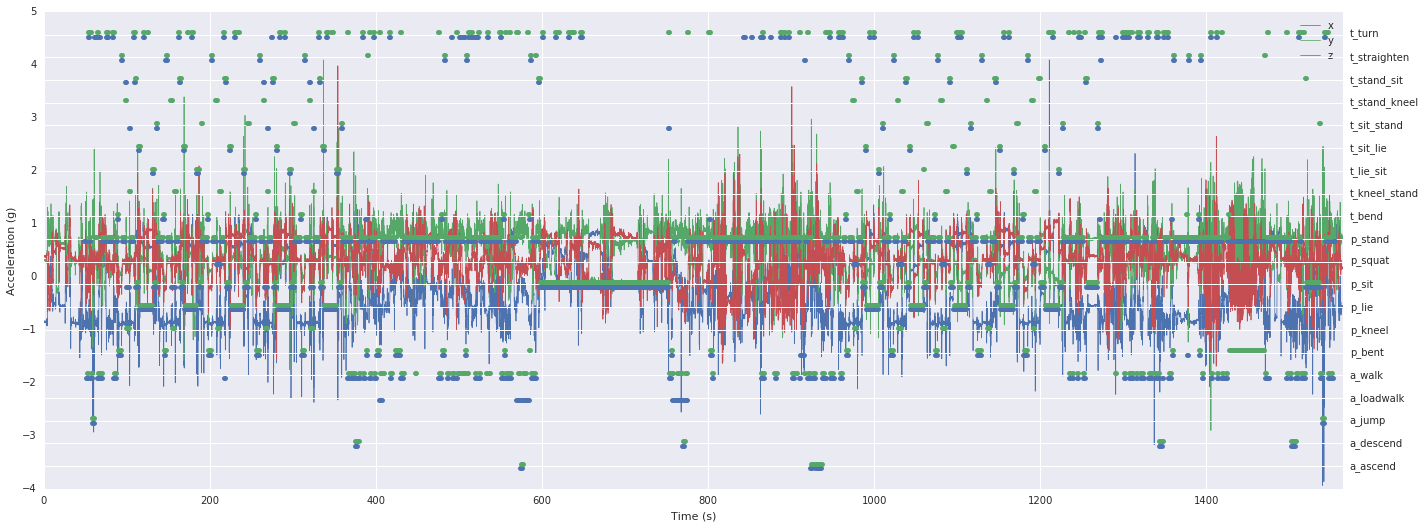

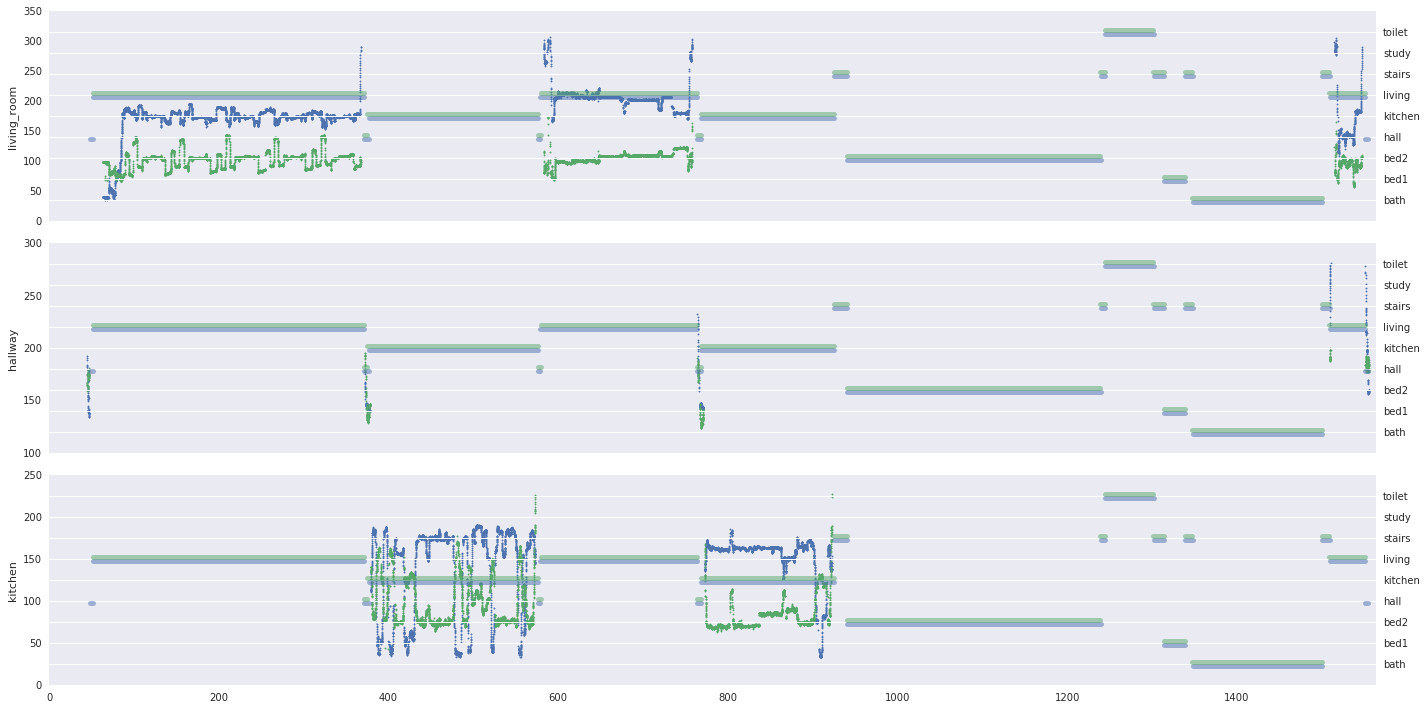

In [13]:
main('00005')

[[(49.196000000000005, 50.977), (1411.3829999999998, 1412.961)], [(49.13, 50.56), (1410.8139999999999, 1412.506)]]


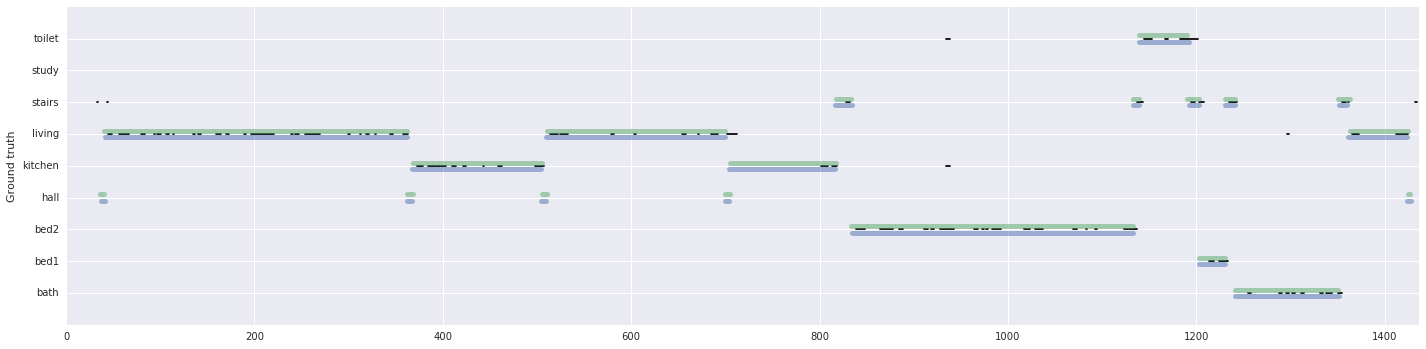

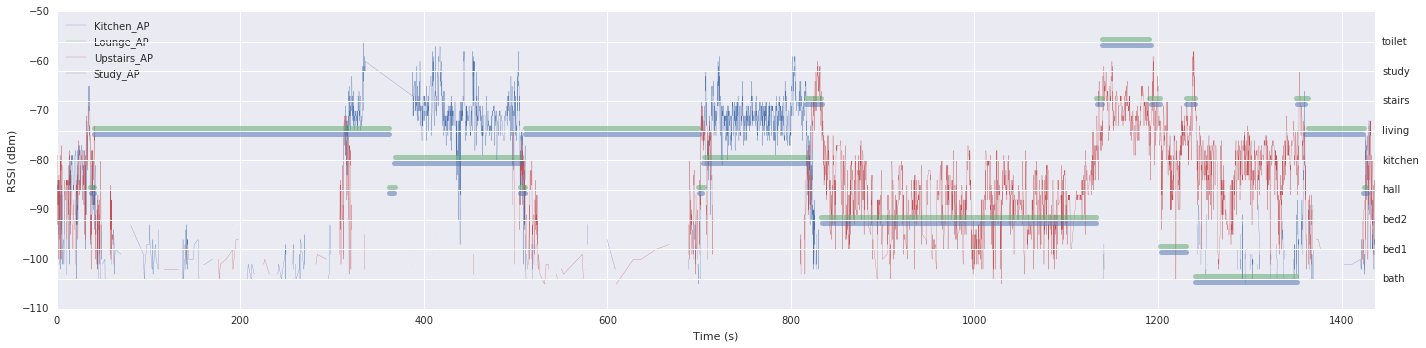

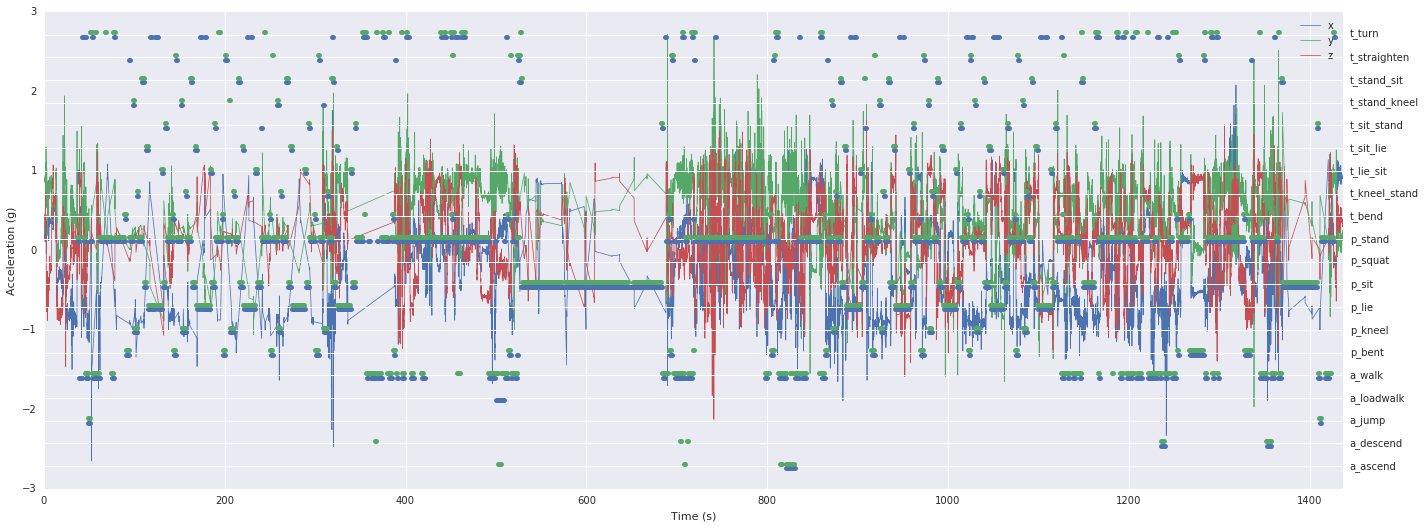

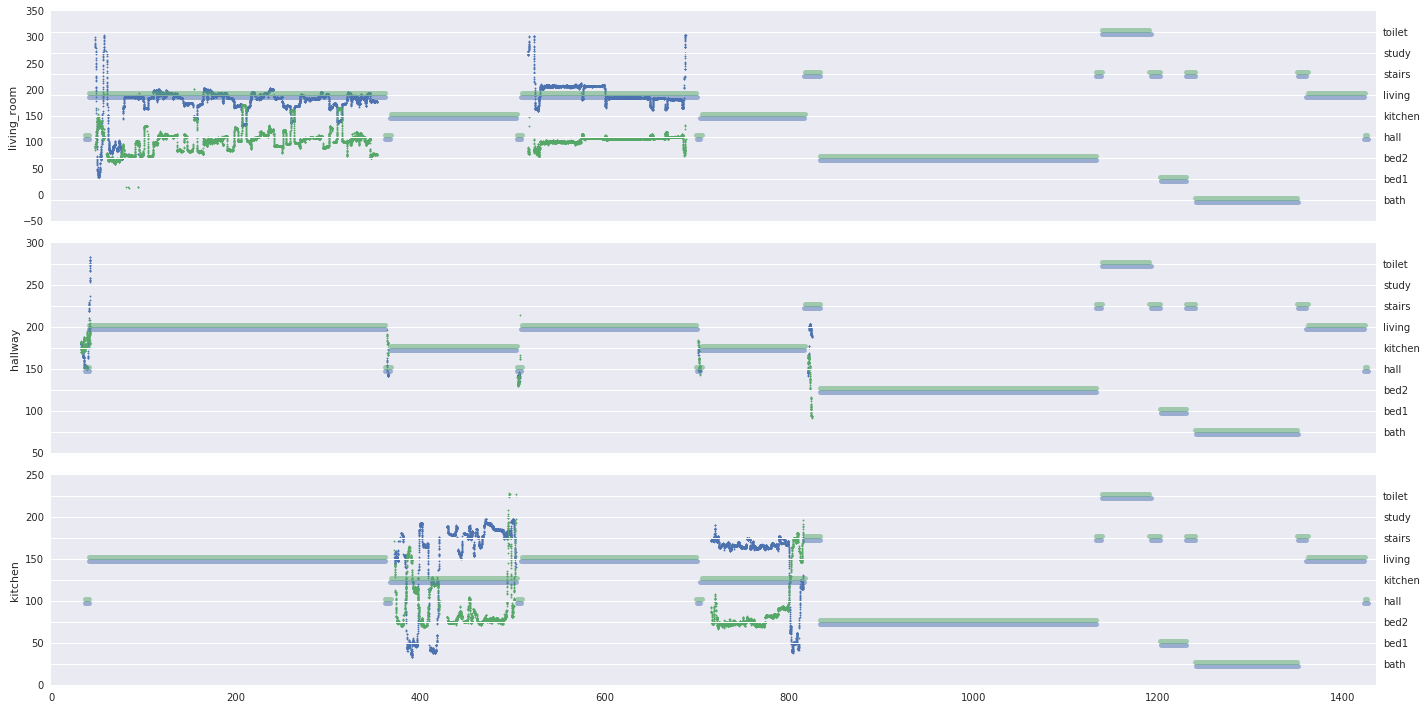

In [14]:
main('00006')

[[(36.83, 38.87), (1489.443, 1490.866)], [(37.145, 38.935), (1489.165, 1490.615)]]


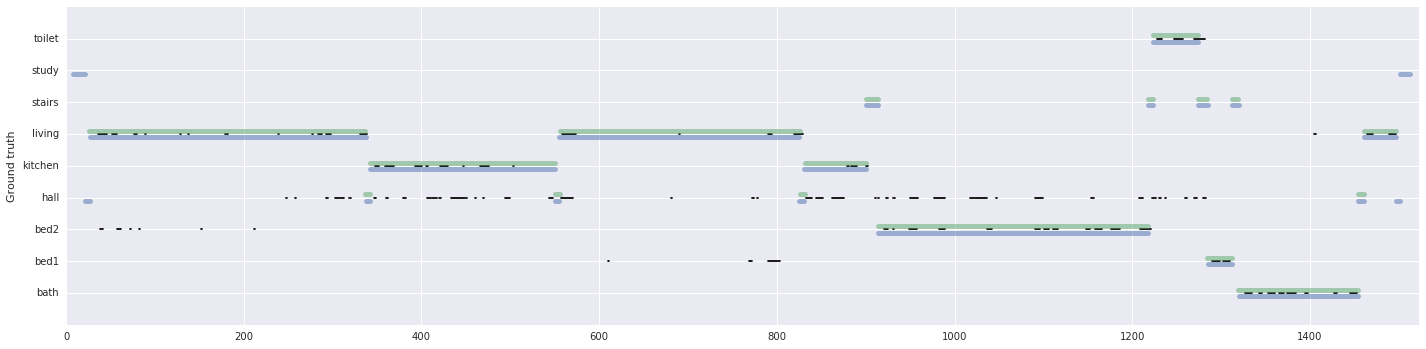

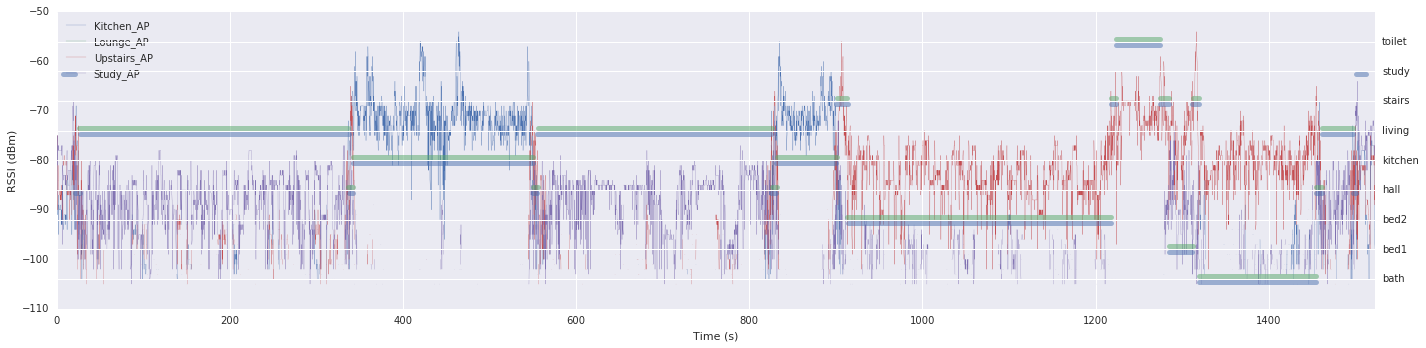

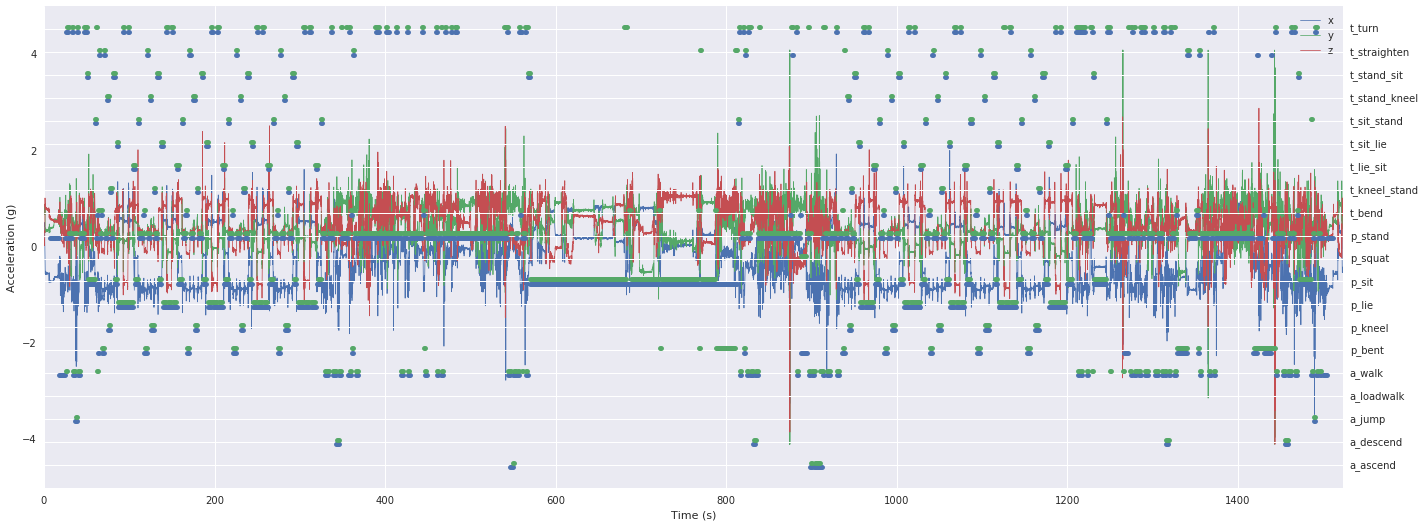

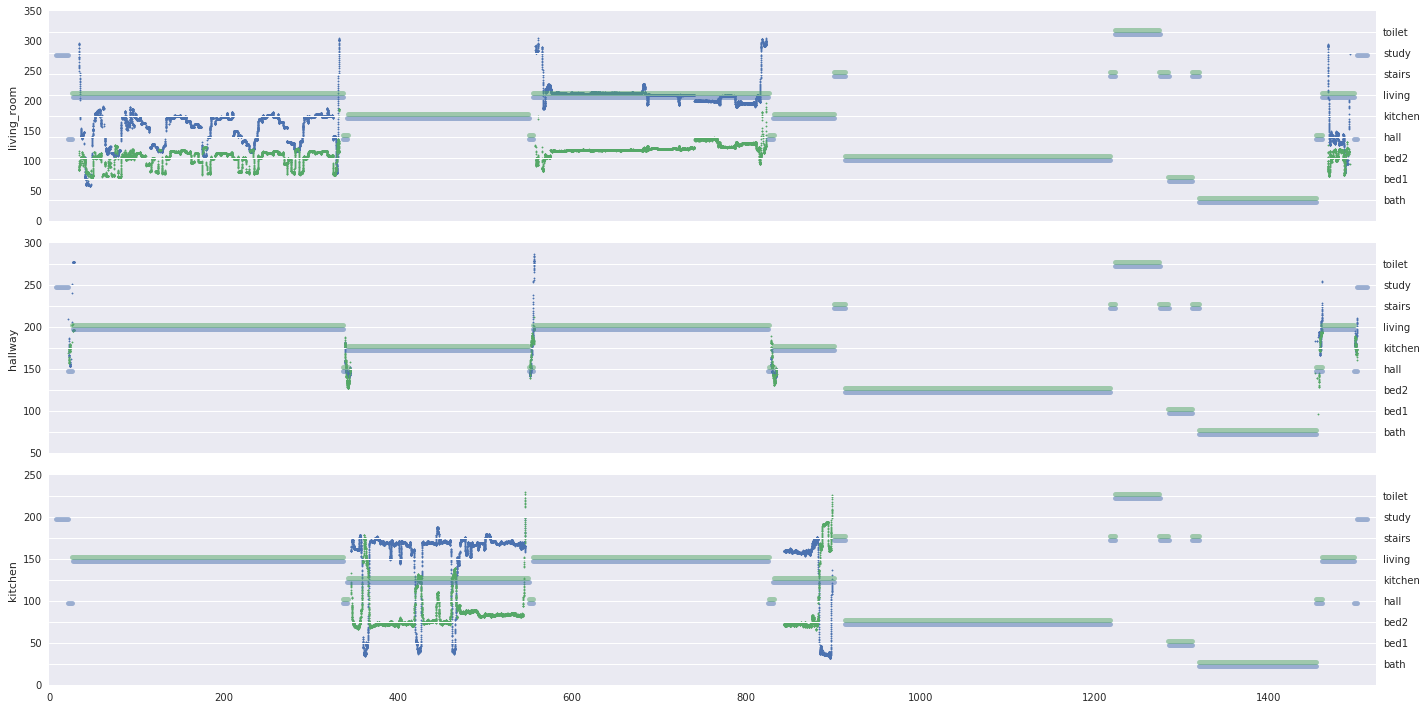

In [15]:
main('00007')

[[(50.222, 52.117), (1702.287, 1703.3029999999999)], [(50.015, 52.165), (1702.295, 1703.355)]]


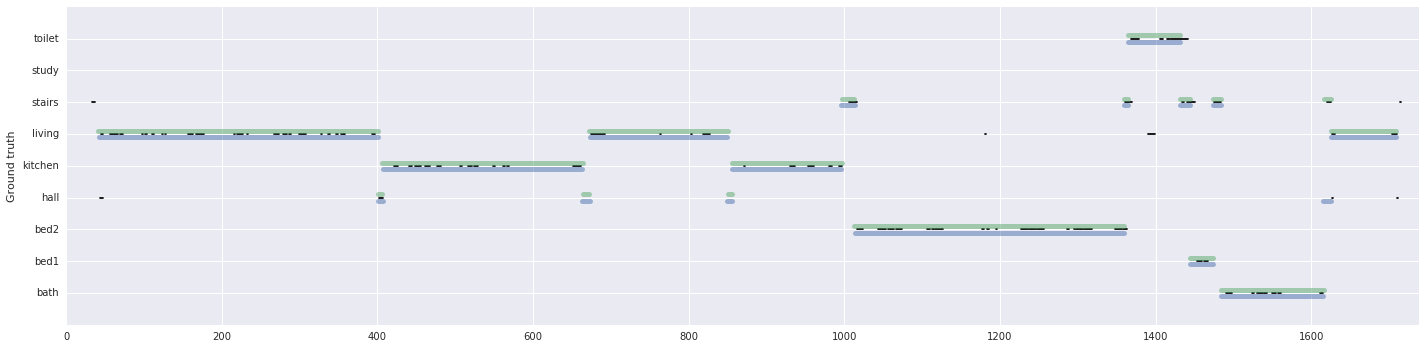

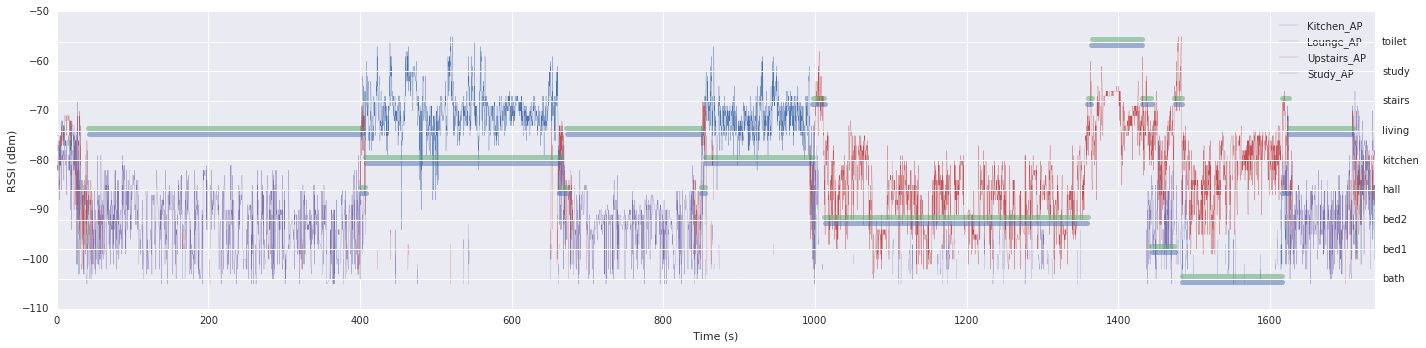

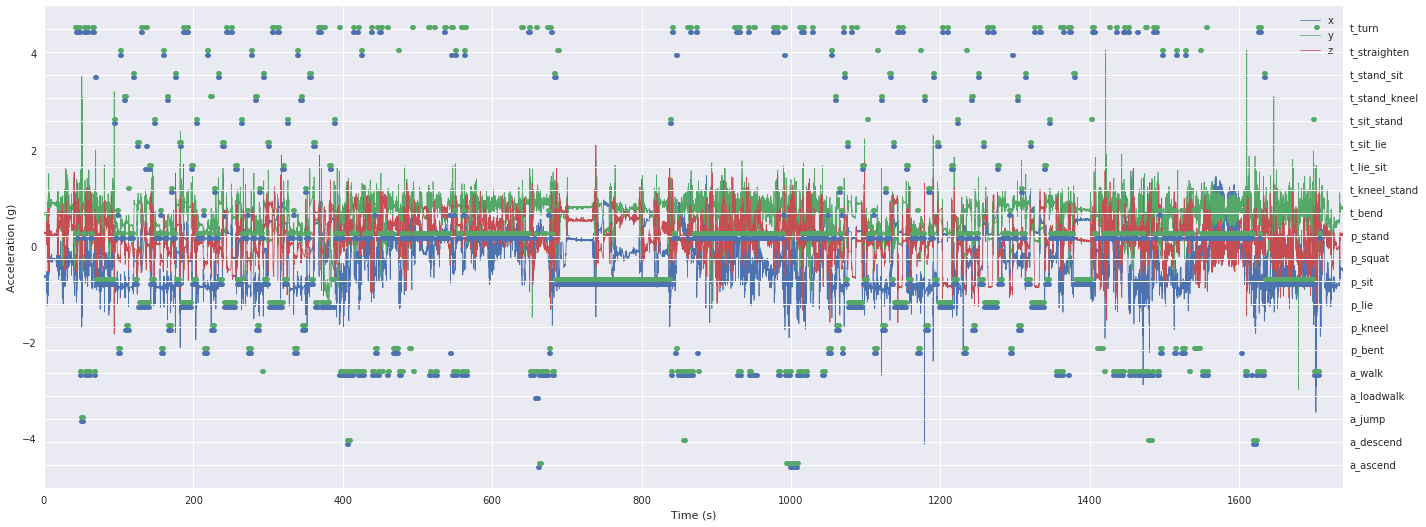

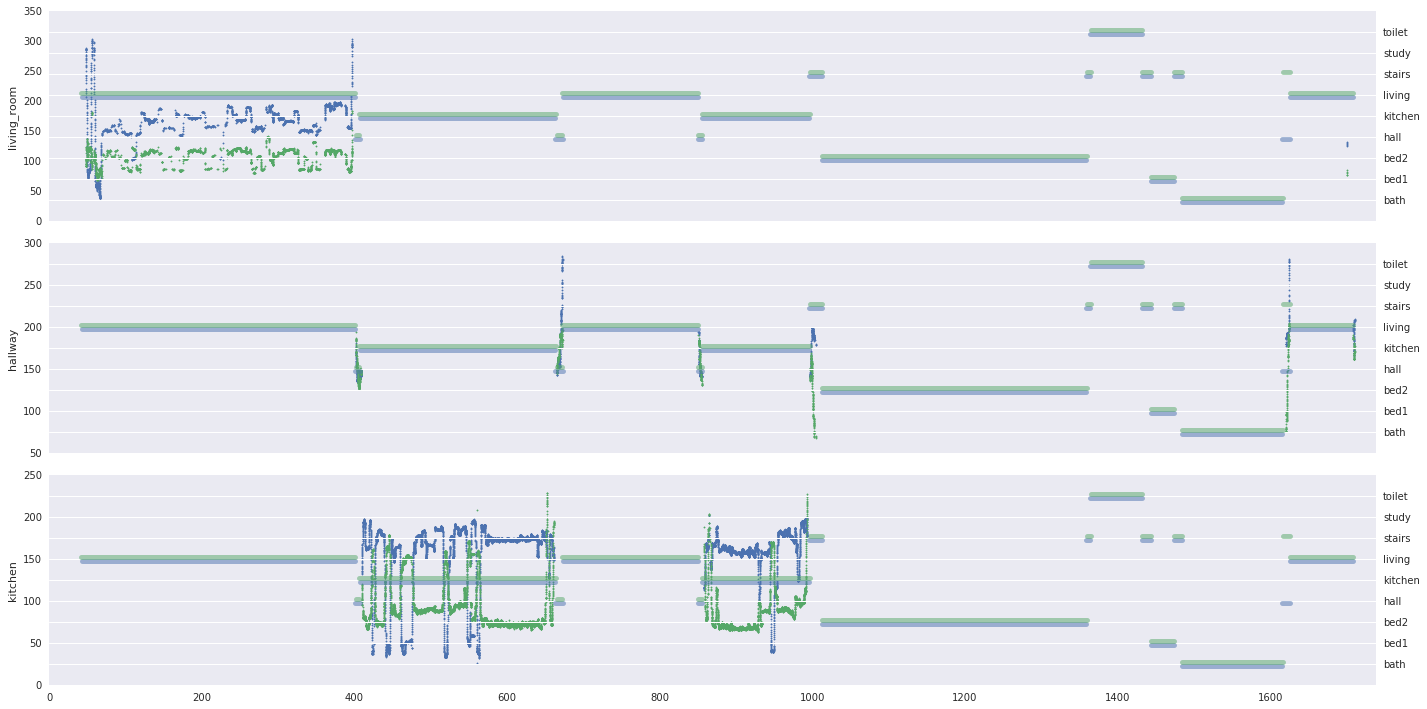

In [16]:
main('00008')

[[(44.887, 47.568999999999996), (1806.2939999999999, 1808.09)], [(44.715, 47.215), (1805.259, 1807.851)]]


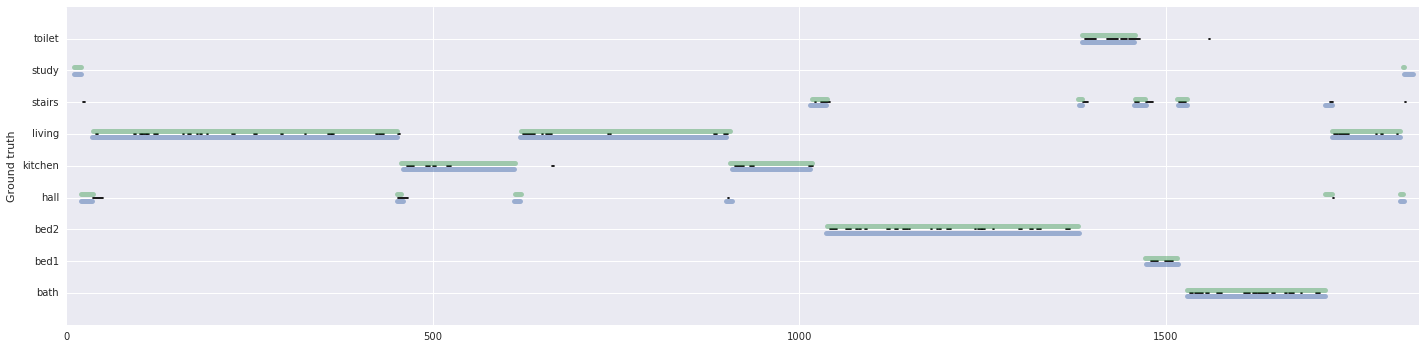

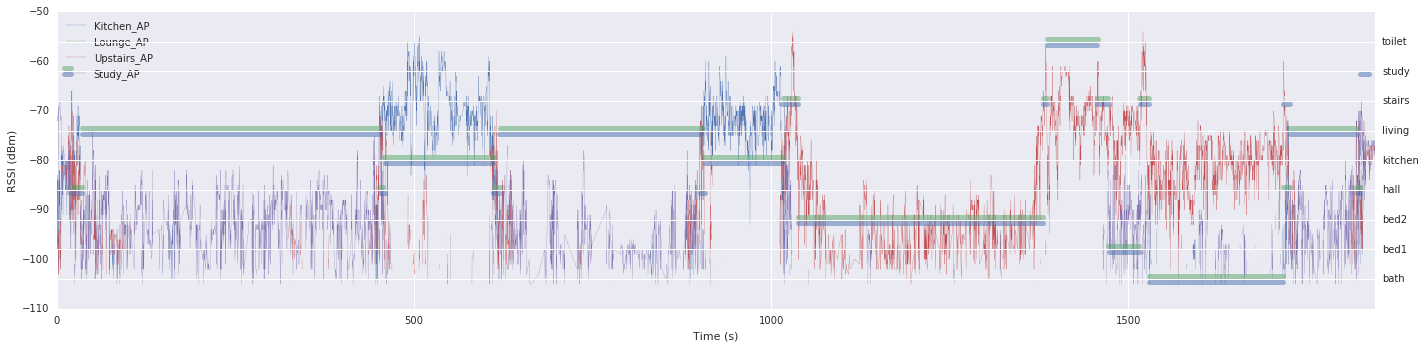

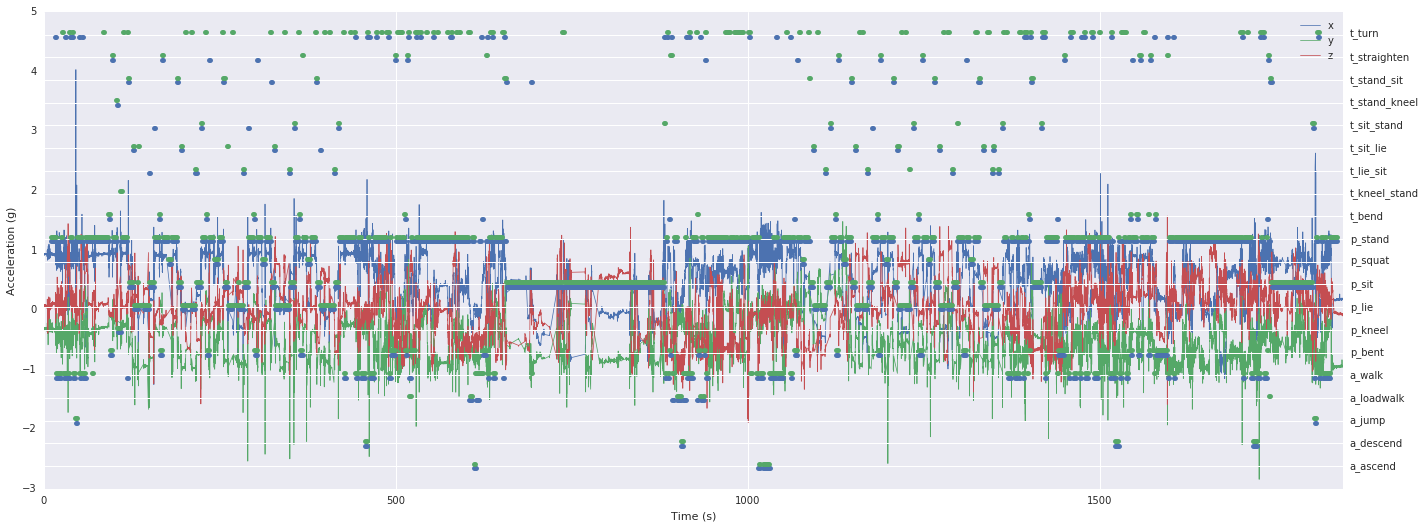

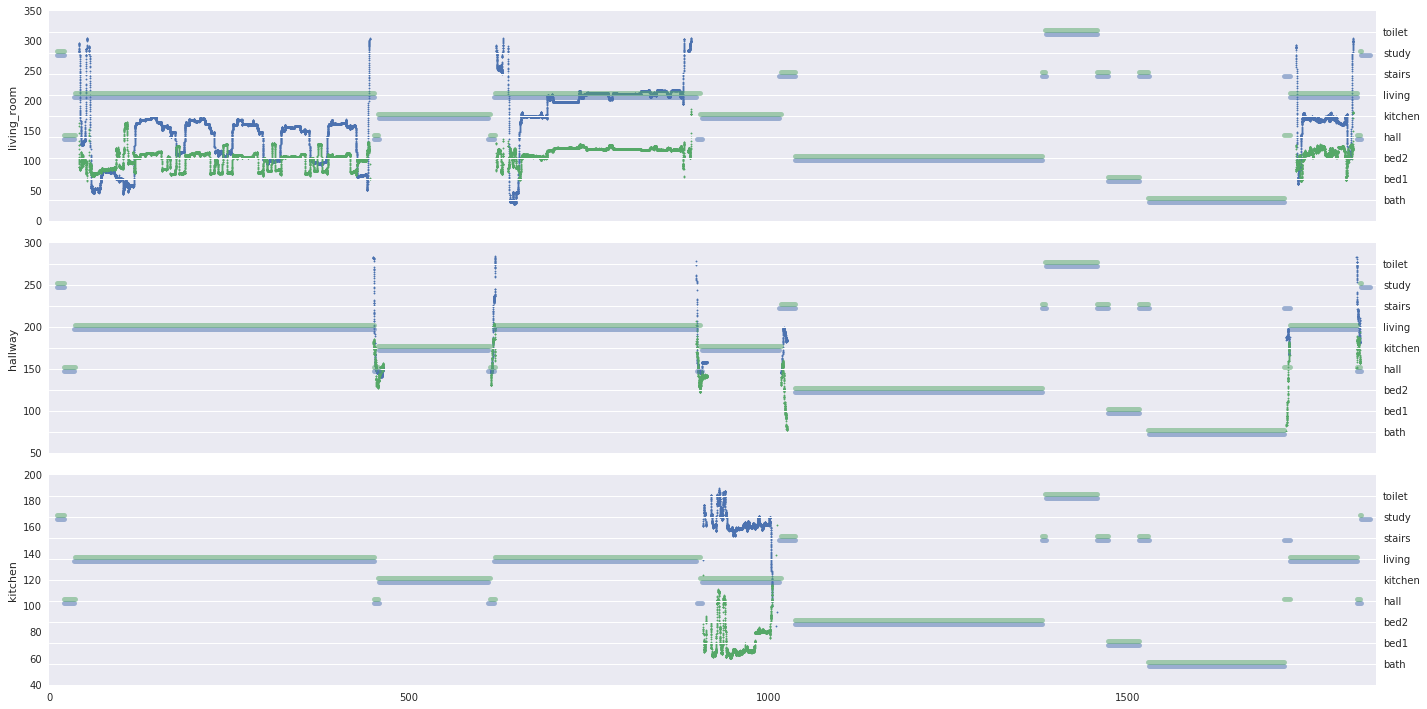

In [17]:
main('00009')

[[(99.85, 102.1), (1749.9270000000001, 1753.06)], [(99.82700000000001, 102.07799999999999), (1750.4589999999998, 1753.234)]]


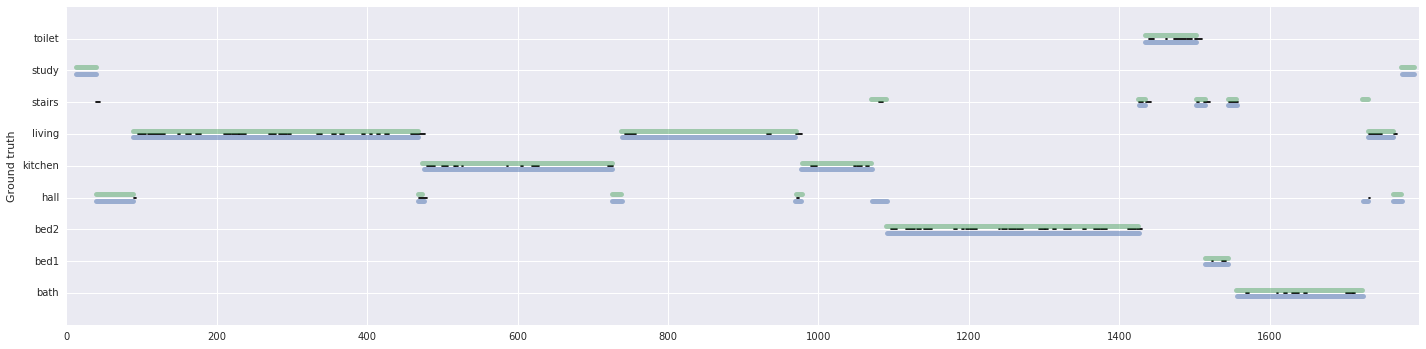

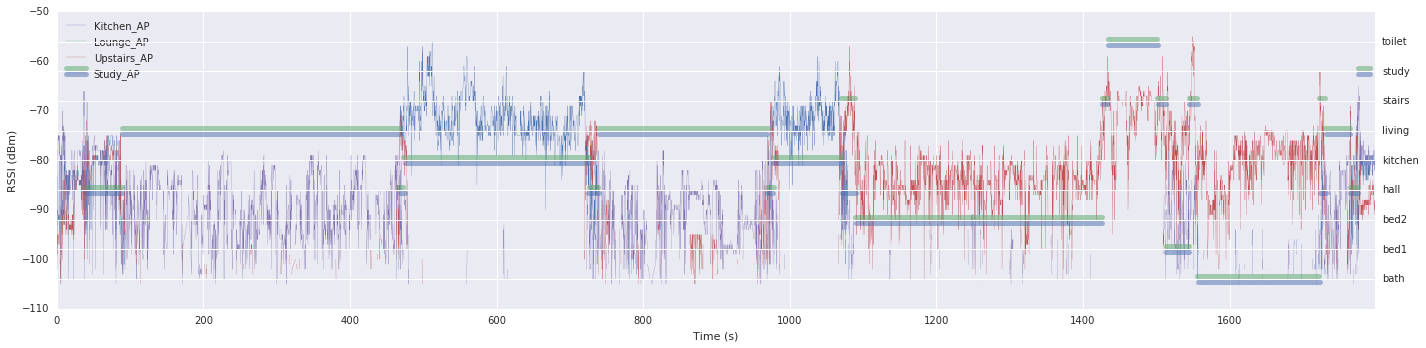

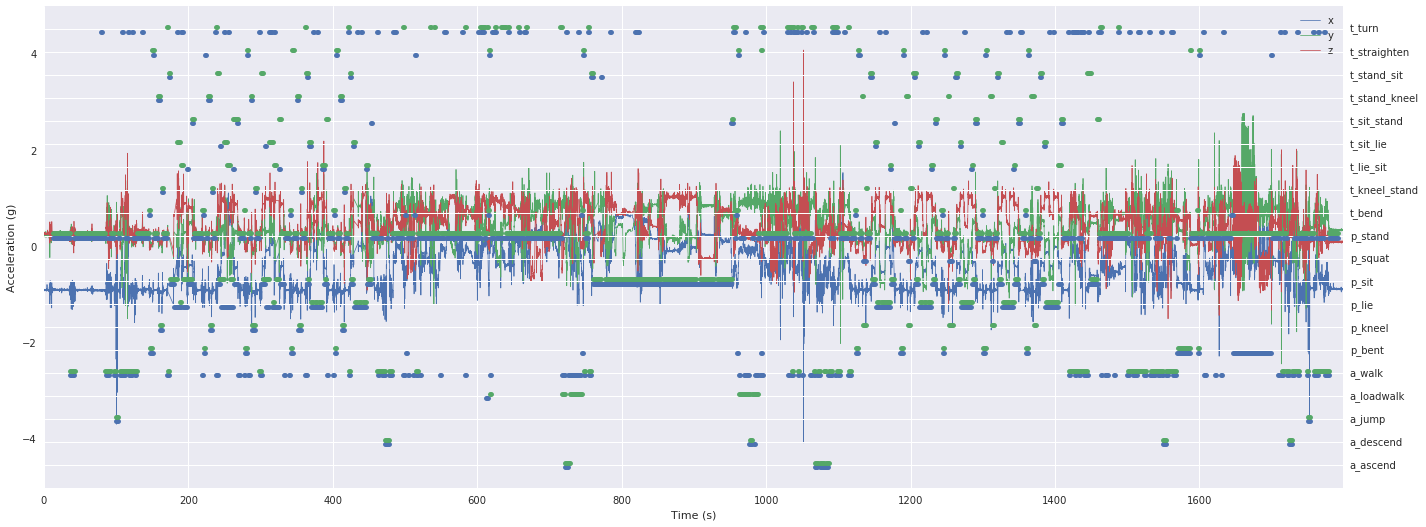

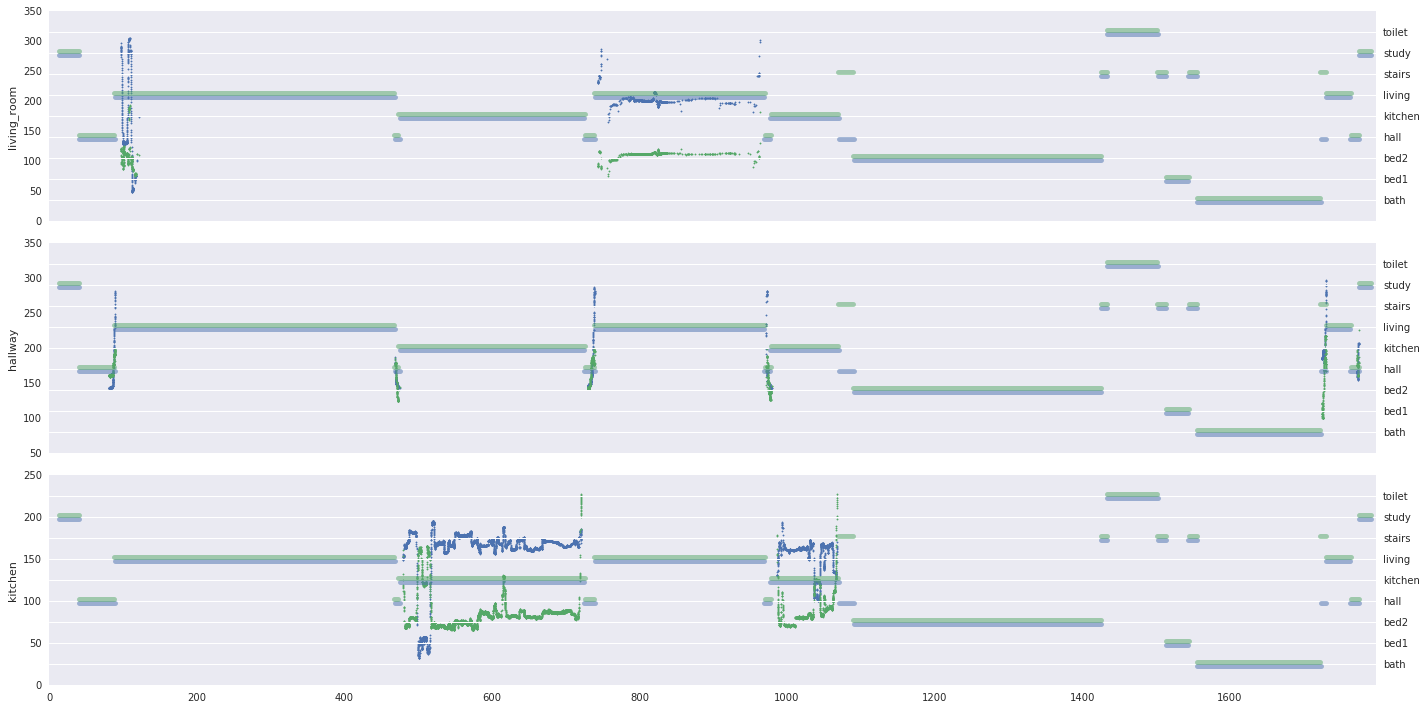

In [19]:
main('00010')

In [22]:
main('00011')

FileNotFoundError: [Errno 2] No such file or directory: '/SPHERE-Challenge/data/raw_data/public_data/train/00011/meta.json'